#Logistic Regression Homework

- Use the full dataset -- all columns. ✗ <font color='blue'> ☹️ Couldn't find the data on Google drive so I grabbed a different data set.</font>

- Try our quick algorigthm and see if it's any good ✓ <font color='blue'>Not bad.  With standardized regressors, we outperformed the toward data science post I borrowed (Accuracy 0.88 vs 0.74).</font>

- Try SKLearn on the same data, see if you do any better ✓ <font color='blue'>Sklearn did a little better (Accuracy - 0.91 vs 0.88; F1 - 0.523 vs 0.34).</font>

- Combine random walk with Logistic regression -- does it improve results? ✗ <font color='blue'> ☹️ I'm not sure what this is asking me to do.  I tried the random walk to find optimal weights and it didn't seem to work too well.</font>

- How do we optimize the learning rate? -- you can use gradient descent; balance oscillations with speed of convergeance

**I added in scaling on the quantitative variables and WAY outpeformed the person who wrote this post - a post that has over 11 thousand claps.  I also added a bettter model evaluation summary / confusion matrix. Last I properly evaluated my model against a true test set, not the synthetic data they came up with.**


The majority of my code is taken from this toward data science post https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8.  The analysis interpretation is solely mine. I did my own interpretation and then read the post.


<font color='red'>**Question:** The comments on the article from medium tell the author she should have used the synthetically generated data to train the classifier and evaluated the model performance using the original test data.  The synthetic data set is balanced (i.e. - has an equal number of positive and negative responses).  The actual data has 88% positive and 11% negative cases.  What is the correct way to do this? </font> 

In [ ]:
# Mount data drive
from google.colab import drive
drive.mount('/data/')
data_dir = '/data/My Drive/EMSE 6575/LogisticRegressionHomework'

Mounted at /data/


In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
# Read the data - 
# Data is marketing campaign data for a bank where the goal is to predict whether the client will subscribe to a term deposit.
data = pd.read_csv(data_dir + '/loan_data.csv', header = 0)
data = data.dropna()
print(data.shape)
data.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,outcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [ ]:
# Relabel education categories so there are less values
data['education'] = np.where(data['education'] == 'basic.9y', 'Basic', data['education'])
data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education'])
data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education'])
data['education'].value_counts()

Basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1731
illiterate                18
Name: education, dtype: int64

0    36548
1     4640
Name: y, dtype: int64


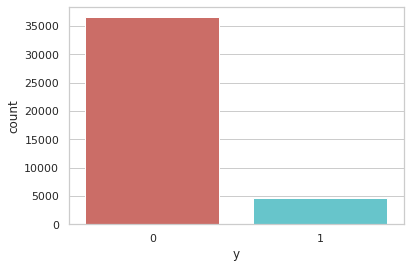

In [ ]:
# Explore response variable to determine how many trues there are
print(data['y'].value_counts())
sns.countplot(x = 'y', data = data, palette = 'hls')
plt.show()

In [ ]:
# Determine if the prediciton classes are balanced
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


In [ ]:
# Examine if there are any obvious differences in the explanatory variables between classes
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Looks like people who subscribed were on the phone longer (duraction was 553 compared to 220).  The `pdays` mean doesn't seem like a good measure since 999 means the client was not previously contacted.  However, we can tell people who said yes are contacted more frequently than people who said no and were more likely to have been contacted in the previous quarter (previous 0.49 is greater than 0.132).  


In [ ]:
# Look at trends within categorical variables
print(data['job'].value_counts())
data.groupby('job').mean()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


Young students have the highest subscription rate (31.4%) followed by older retired people (25.2%).  Howver, students make up only a small percentage of the sample - only 875 students in the data.

In [ ]:
print(data['marital'].value_counts())
data.groupby('marital').mean()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


Not much to speak of on this one, other than single people have a higher percentage of successful subscpription than divorced or married.  Makes sense considering how many students sign up.  The unknown category also has high percentages but only makes up 80 people in the data.

In [ ]:
print(data['education'].value_counts())
data.groupby('education').mean()

Basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1731
illiterate                18
Name: education, dtype: int64


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


This one suffers the same issues with unbalance sampling like the job table.  Illiterate people appear to have the highest subscription rate (22.2%), but only 18 people described themselves as illiterate.  However, also looks like people with a university degree are more likely to be subscriber than other categories.

Text(0, 0.5, 'Frequency of Purchase')

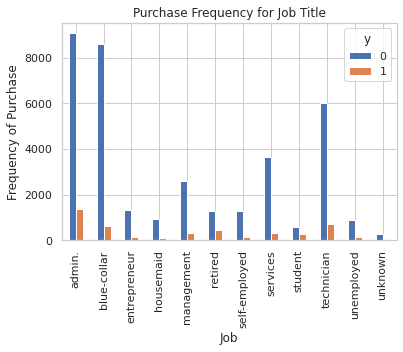

In [ ]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

This is a good plot because you can visually see which categories have high subscription rates (i.e., the blue and orange bars are closer in height for student and retired), but you can also see they make up a very small percentage of th total subscriptions (i.e., admin is the top job category to generate subscriptions).  It also shows that the percentage of subscriptions varies within job categories; hence, knowing the type of job should help us predict whether or not a person subscribes.  In other words, if we randomly draw a student, they have a higher chance of being a subscriber than if we draw a blue-collar worker.


Text(0, 0.5, 'Proportion of Customers')

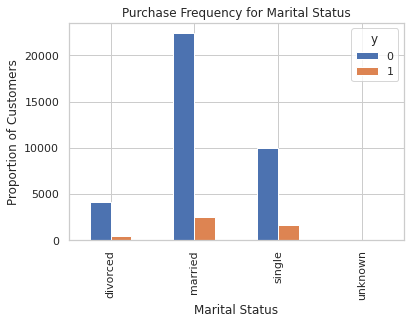

In [ ]:
%matplotlib inline
pd.crosstab(data.marital,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Same as I stated above.  Single people has a slightly higher proportion of subscriptions within their category than others.

Text(0, 0.5, 'Proportion of Customers')

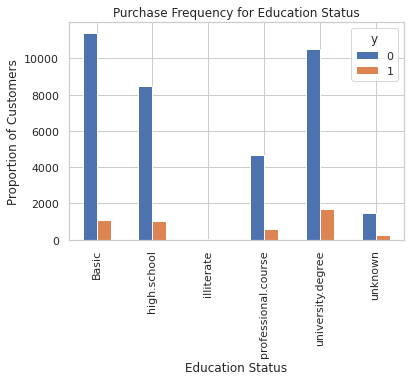

In [ ]:
%matplotlib inline
pd.crosstab(data.education,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Education Status')
plt.xlabel('Education Status')
plt.ylabel('Proportion of Customers')

No change from above.  University degree seems to be predictive over other categories.  However, comparisons across other categories like basic and high.school seem less useful.

**In summary, the diagnostic plots make it seem like newly graduated, single people are more likely to sign up for a term subscription than other types of people**

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64


Text(0, 0.5, 'Proportion of Customers')

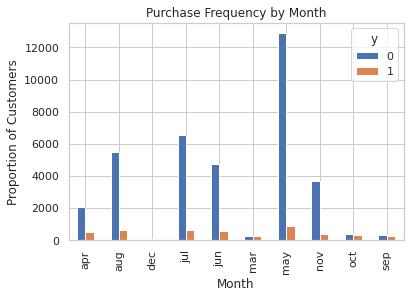

In [ ]:
print(data['month'].value_counts())
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Proportion of Customers')

Looks like march, september, and october tend to be more successful months in terms of percentages.  No idea why this would be the case other than, the fiscal year starts on October 1st.  But for model training, it seems like month is going to be very predictive.  If we are predicting something in any of those months, it should have better odds at being a success.

In [ ]:
# One-hot encode the categorical variables 
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','outcome']
for var in cat_vars:
  cat_list='var'+'_'+var
  cat_list = pd.get_dummies(data[var], prefix=var)
  data1=data.join(cat_list)
  data=data1

cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','outcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

In [ ]:
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()

numeric_vars = ['age', 'duration', 'campaign', 'pdays', 'emp_var_rate', 'cons_price_idx', 
                'cons_conf_idx', 'euribor3m', 'nr_employed']

#only standardize numerical features
features=data_final[numeric_vars]
features_standard=StandardScaler().fit_transform(features)# Gaussian Standardisation
temp=pd.DataFrame(features_standard,columns=numeric_vars)
temp

,age,duration,campaign,pdays,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0.381527,-0.186230,-0.565922,0.195414,0.839061,-0.227465,0.951267,0.773575,0.845170
1,1.245157,-0.463926,-0.565922,0.195414,-0.115781,-0.649003,-0.323542,0.230456,0.398115
2,-1.153816,0.311309,0.156105,-5.117342,-1.134279,0.828107,0.151810,-1.667578,-2.428157
3,-0.098268,-0.282652,-0.204909,0.195414,-1.197935,-0.864955,-1.425496,-1.277824,-0.940281
4,1.437075,-0.467783,-0.565922,-5.133393,-1.898153,-2.374889,1.966794,-1.586859,-1.257233
...,...,...,...,...,...,...,...,...,...
41183,1.820911,-0.139947,-0.565922,0.195414,0.839061,1.536429,-0.280328,0.717649,0.845170
41184,-0.865939,-0.240227,-0.204909,0.195414,0.648092,0.722722,0.886447,0.714190,0.331680
41185,0.189609,-0.757050,0.156105,0.195414,0.648092,0.722722,0.886447,0.712460,0.331680
41186,0.765363,-0.224799,-0.204909,0.195414,-2.216433,-1.977538,2.939106,-1.660082,-2.069683


In [ ]:
cat_data = data_final[['job_admin.', 'job_blue-collar', 'job_entrepreneur',
                        'job_housemaid', 'job_management', 'job_retired',
                        'job_self-employed', 'job_services', 'job_student',
                        'job_technician', 'job_unemployed', 'job_unknown',
                        'marital_divorced', 'marital_married', 'marital_single',
                        'marital_unknown', 'education_Basic', 'education_high.school',
                        'education_illiterate', 'education_professional.course',
                        'education_university.degree', 'education_unknown', 'default_no',
                        'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
                        'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
                        'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
                        'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
                        'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
                        'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
                        'day_of_week_wed', 'outcome_failure', 'outcome_nonexistent',
                        'outcome_success', 'y']]
data_final_after_standardizing = pd.concat([cat_data.reset_index(drop=True), temp], axis=1)
data_final = data_final_after_standardizing

# SMOTE

With our training data created, I’ll up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:

1. Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [ ]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [ ]:
data_final['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [ ]:
os_data_y['y'].value_counts()

1    25567
0    25567
Name: y, dtype: int64

In [ ]:
y_test['y'].value_counts()

0    10981
1     1376
Name: y, dtype: int64

Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

# Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 25)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True False  True False  True  True  True  True False False False
 False False False False False False  True False False False False  True
 False False  True False False False  True False  True False  True  True
 False  True  True  True  True False  True False False False False False
  True  True  True False  True False False  True  True False  True False]
[22  1  2  1  9  1  1  1  1  8 21 20 19 32 34 14 11 12  1 33 17 10 31  1
 35 28  1 29 23  6  1  7  1  5  1  1  4  1  1  1  1 16  1 25 26 24 27 13
  1  1  1 36  1 15 18  1  1 30  1  3]


In [ ]:
from itertools import compress
cols = list(compress(os_data_X.columns, rfe.support_))
X=os_data_X[cols]
y=os_data_y['y']

In [ ]:
# Implement the model
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.315088
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.545     
Dependent Variable:   y                 AIC:               32273.4687
Date:                 2021-02-11 12:09  BIC:               32494.5238
No. Observations:     51134             Log-Likelihood:    -16112.   
Df Model:             24                LL-Null:           -35443.   
Df Residuals:         51109             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
job_blue-collar      -0.3431   0.0411  -8.3412 0.0000 -0.4238 -0.2625
job_housemaid   

Will remove variables that have coefficient estimates with p-value higher than 0.05. ['education_illiterate']

In [ ]:
remove_cols = ['education_illiterate']
new_cols = [x for x in cols if x not in remove_cols]
X=os_data_X[new_cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.315100
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.545     
Dependent Variable:  y                 AIC:               32272.6253
Date:                2021-02-11 12:09  BIC:               32484.8382
No. Observations:    51134             Log-Likelihood:    -16112.   
Df Model:            23                LL-Null:           -35443.   
Df Residuals:        51110             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
job_blue-collar     -0.3427   0.0411  -8.3317 0.0000 -0.4234 -0.2621
job_housemaid       -0.4215 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

cm = metrics.confusion_matrix(y_test, y_pred)
true_pos = cm[1,1]
true_neg = cm[0,0]
false_pos = cm[0,1]
false_neg = cm[1,0]
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)

print("When we check precision of our model against the test data set, " + str(len(y_test)) + " users")
print("")
print("Precision - We predicted a subscription " + str(cm[1,1] + cm[0,1]) + " times and were correct " + str(cm[1,1]) + " times: " + str(cm[1,1]/(cm[1,1] + cm[0,1]))[0:5])
print("Recall - We predicted " + str(cm[1,1]) + " out of the " + str(cm[1,1] + cm[1,0]) + " subscriptions: " + str(recall)[0:5])
print("")
print("Our total accuracy was " + str((cm[0,0] + cm[1,1])/len(y_test))[0:5])
print("Our F1 score was " + str(2*(precision*recall)/(precision+recall))[0:5])

Accuracy of logistic regression classifier on test set: 0.91
When we check precision of our model against the test data set, 12357 users

Precision - We predicted a subscription 884 times and were correct 592 times: 0.669
Recall - We predicted 592 out of the 1376 subscriptions: 0.430

Our total accuracy was 0.912
Our F1 score was 0.523


In [ ]:
metrics.precision_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)

true_neg = str(cm[0,0]) + "/" + str(cm[0,0] + cm[1,0]) + " (" + str(cm[0,0]/(cm[0,0] + cm[1,0]))[0:5] + ")"
false_pos = str(cm[0,1]) + "/" + str(cm[0,1] + cm[1,1]) + " (" + str(cm[0,1]/(cm[0,1] + cm[1,1]))[0:5] + ")"
false_neg = str(cm[1,0]) + "/" + str(cm[1,0] + cm[0,0]) + " (" + str(cm[1,0]/(cm[1,0] + cm[0,0]))[0:5] + ")"
true_pos = str(cm[1,1]) + "/" + str(cm[1,1] + cm[0,1]) + " (" + str(cm[1,1]/(cm[1,1] + cm[0,1]))[0:5] + ")"

conf_matrix = pd.DataFrame({'Not Subscription': [true_neg, false_neg],
                            'Subscription': [false_pos, true_pos],
                            'Support': [cm[0,0] + cm[0,1], cm[1,0] + cm[1,1]]},
                    index = ['Not Subscription', 'Subscription'])
conf_matrix

,Not Subscription,Subscription,Support
Not Subscription,10689/11473 (0.931),292/884 (0.330),10981
Subscription,784/11473 (0.068),592/884 (0.669),1376


In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10981
           1       0.67      0.43      0.52      1376

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357



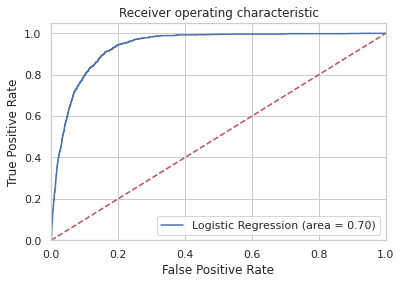

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Now to test this with the code we made in class.

In [ ]:
from numpy.random import rand, randint
from numpy import log, dot, e
epsilon = 0.00000000000000000000000000001

def sigmoid(z): return (1 / (1 + e**(-z)))

#### STARTING CONDITION -->> RANDOM
weights = rand(X_train.shape[1])

#### BLACK BOX 
def predict(X):
  z=sigmoid(dot(X,weights))
  return([1 if i > 0.5 else 0 for i in z])

### COST FUNCTION ---> this is how good our whole algorithm is
def cost_function(X,y,weights):
  y_hat = sigmoid(dot(X,weights))
  pred_1 = y*log(y_hat+epsilon)
  pred_0 = (1-y)*log(1-y_hat+epsilon)
  mean = - sum(pred_1 + pred_0)/len(X)
  return(mean)

In [ ]:
X = X_train[['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'outcome_failure', 'outcome_nonexistent',
       'outcome_success', 'age', 'duration', 'campaign', 'pdays',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed']]
y = y_train['y']
yh=cost_function(X,y,weights)

In [ ]:
def random_walk(X,y):
  best_weights = []
  best_cost = 1000000000
  cost = []

  for _ in range(25):
    weights = rand(X.shape[1])
    c = cost_function(X,y,weights) #<<<---- $$$$ cost
    if c < best_cost:
      best_cost=c
      best_weights=weights
    cost.append(c)

  return(cost,best_weights)

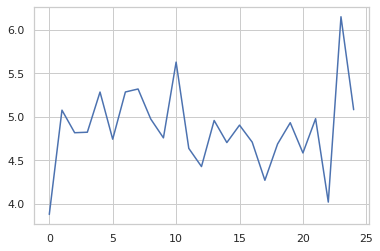

In [ ]:
loss, weights = random_walk(X,y)
plt.plot(loss)

In [ ]:
def fit(X,y,epochs=25,lr=0.01):
  loss = []
  weights = rand(X.shape[1])
  n = len(X)
  for _ in range(epochs):
    y_hat = sigmoid(dot(X,weights))
    delta = lr* dot(X.T, y_hat-y)/n
    weights -= delta
    loss.append(cost_function(X,y,weights))

    ### better stopping condition - derivative
    #if sum(delta)/len(delta) < 0.001:
    #  break

  return(loss,weights)

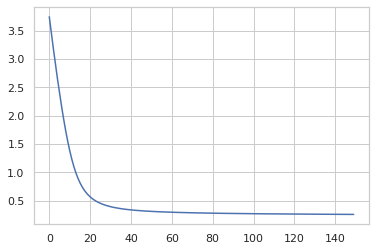

In [ ]:
loss,weights = fit(X,y,epochs = 150, lr=0.1)
plt.plot(loss)

In [ ]:
prediction_df = pd.DataFrame({'prediction': predict(X), 'truth': y})
prediction_df['result'] = None
prediction_df.head()

,prediction,truth,result
31880,0,0,None
38177,0,0,None
2459,0,0,None
756,0,0,None
11275,0,0,None


In [ ]:
prediction_df['result'][(prediction_df['prediction'] == 0) & (prediction_df['truth'] == 0)] = "true_neg"
prediction_df['result'][(prediction_df['prediction'] == 0) & (prediction_df['truth'] == 1)] = "false_neg"
prediction_df['result'][(prediction_df['prediction'] == 1) & (prediction_df['truth'] == 0)] = "false_pos"
prediction_df['result'][(prediction_df['prediction'] == 1) & (prediction_df['truth'] == 1)] = "true_pos"
results = prediction_df['result'].value_counts()
results

true_neg     24640
false_neg     2071
true_pos      1193
false_pos      927
Name: result, dtype: int64

In [ ]:

true_pos = results[3]
true_neg = results[0]
false_pos = results[1]
false_neg = results[2]
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)

print("When we check precision of our model against the test data set, " + str(len(y)) + " users")
print("")
print("Precision - We predicted a subscription " + str(true_pos + false_pos) + " times and were correct " + str(true_pos) + " times: " + str(true_pos/(true_pos + false_pos))[0:5])
print("Recall - We predicted " + str(true_pos) + " out of the " + str(true_pos + false_neg) + " subscriptions: " + str(recall)[0:5])
print("")
print("Our total accuracy was " + str((true_pos + true_neg)/len(y))[0:5])
print("Our F1 score was " + str(2*(precision*recall)/(precision+recall))[0:5])

When we check precision of our model against the test data set, 28831 users

Precision - We predicted a subscription 2998 times and were correct 927 times: 0.309
Recall - We predicted 927 out of the 2120 subscriptions: 0.437

Our total accuracy was 0.886
Our F1 score was 0.362
